In [1]:
import base64
import io
import pickle
import numpy as np
import torch
print(f'TORCH VERSION: {torch.__version__}') 
import packaging.version
if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'): raise RuntimeError('Torch versions lower than 1.5.0 not supported')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

TORCH VERSION: 1.12.1


In [2]:
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    torch.set_default_tensor_type(torch.DoubleTensor)
print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cpu


In [3]:
def torch_mod(x):
    return torch.remainder(x, 2*np.pi)
def torch_wrap(x):
    return torch_mod(x+np.pi) - np.pi

def grab(var):
    return var.detach().cpu().numpy()

In [4]:
from IPython.display import display

def init_live_plot(dpi=125, figsize=(8,4)):
    fig, ax_loss = plt.subplots(1,1, dpi=dpi, figsize=figsize)
    plt.xlim(0, N_era*N_epoch)
    plt.ylim(0, 1)
    
    #ess_line = plt.plot([0],[0], alpha=0.5) # dummy
    #plt.grid(False)
    #plt.ylabel('Loss')
    
    #ax_loss = ax_loss
    loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy
    plt.grid(False)
    plt.ylabel('Loss')
    
    plt.xlabel('Epoch')

    display_id = display(fig, display_id=True)

    return dict(
        fig=fig,ax_loss=ax_loss, loss_line=loss_line,
        display_id=display_id
    )

def moving_average(x, window=10):
    if len(x) < window:
        return np.mean(x, keepdims=True)
    else:
        return np.convolve(x, np.ones(window), 'valid') / window

def update_plots(history, fig, ax_loss, loss_line, display_id):
    #Y = np.array(history['ess'])
    #Y = moving_average(Y, window=15)
    #ess_line[0].set_ydata(Y)
    #ess_line[0].set_xdata(np.arange(len(Y)))
    Y = history['loss']
    Y = moving_average(Y, window=15)
    loss_line[0].set_ydata(np.array(Y))
    loss_line[0].set_xdata(np.arange(len(Y)))
    ax_loss.relim()
    ax_loss.autoscale_view()
    fig.canvas.draw()
    display_id.update(fig) # need to force colab to update plot

In [5]:
class SimpleNormal:
    def __init__(self, loc, var):
        self.dist = torch.distributions.normal.Normal(
            torch.flatten(loc), torch.flatten(var))
        self.shape = loc.shape
    def log_prob(self, x):
        logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
        return torch.sum(logp, dim=1)
    def sample_n(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x.reshape(batch_size, *self.shape)

In [6]:
L=8
lattice_shape = (L,L) 
link_shape = (2,L,L)
# some arbitrary configurations
u1_ex1 = 2*np.pi*np.random.random(size=link_shape).astype(float_dtype)
u1_ex2 = 2*np.pi*np.random.random(size=link_shape).astype(float_dtype)
cfgs = torch.from_numpy(np.stack((u1_ex1, u1_ex2), axis=0)).to(torch_device)

In [7]:
 def compute_u1_plaq(links, mu, nu):
    """Compute U(1) plaquettes in the (mu,nu) plane given `links` = arg(U)""" 
    return (links[:,mu] + torch.roll(links[:,nu], -1, mu+1)
            - torch.roll(links[:,mu], -1, nu+1) - links[:,nu])

In [8]:
class WilsonAction:
    def __init__(self, beta):
        self.beta = beta
        
    def __call__(self, config):
        action = 0.0
        L = config.shape[1]
        for x0 in range(L):
            for x1 in range(L):
                x = (x0, x1)
                U_plaq = compute_u1_plaq(config,x0,x1)
                action += (1 - torch.cos(U_plaq)).sum().item()
        return -self.beta * action
        
    def plaquette(self, x, config):
        L = config.shape[1]
        U_mu = config[0, x[0], x[1]]
        U_munu = config[1, (x[0] + 1) % L, x[1]]
        U_nu = config[0, x[0], (x[1] + 1) % L]
        U_nu_mu = config[1, x[0], x[1]]
        
        return U_mu + U_munu - U_nu - U_nu_mu
    




In [9]:
beta = 1
u1_action = WilsonAction(beta)

In [10]:
class MultivariateUniform(torch.nn.Module): 
    """Uniformly draw samples from [a,b]""" 
    def __init__(self, a, b):
        super().__init__()
        self.dist = torch.distributions.uniform.Uniform(a, b)
    def log_prob(self, x):
        axes = range(1, len(x.shape))
        return torch.sum(self.dist.log_prob(x), dim=tuple(axes))
    def sample_n(self, batch_size):
        return self.dist.sample((batch_size,))

In [11]:
prior = MultivariateUniform(torch.zeros(link_shape), 2*np.pi*torch.ones(link_shape)) 
z = prior.sample_n(17)
print(f'z.shape = {z.shape}')
print(f'log r(z) = {grab(prior.log_prob(z))}')

z.shape = torch.Size([17, 2, 8, 8])
log r(z) = [-235.2482645 -235.2482645 -235.2482645 -235.2482645 -235.2482645
 -235.2482645 -235.2482645 -235.2482645 -235.2482645 -235.2482645
 -235.2482645 -235.2482645 -235.2482645 -235.2482645 -235.2482645
 -235.2482645 -235.2482645]


In [12]:
class GaugeEquivCouplingLayer(torch.nn.Module):
    """U(1) gauge equiv coupling layer defined by `plaq_coupling` acting on plaquettes.""" 
    def __init__(self, *, lattice_shape, mask_mu, mask_off, plaq_coupling):
        super().__init__()
        link_mask_shape = (len(lattice_shape),) + lattice_shape
        self.active_mask = make_2d_link_active_stripes(link_mask_shape, mask_mu, mask_off)
        self.plaq_coupling = plaq_coupling
        
    def forward(self, x):
        plaq = compute_u1_plaq(x, mu=0, nu=1)
        new_plaq, logJ = self.plaq_coupling(plaq)
        delta_plaq = new_plaq - plaq
        delta_links = torch.stack((delta_plaq, -delta_plaq), dim=1) # signs for U vs Udagger 
        fx = self.active_mask * torch_mod(delta_links + x) + (1-self.active_mask) * x
        return fx, logJ
    
    def reverse(self, fx):
        new_plaq = compute_u1_plaq(fx, mu=0, nu=1)
        plaq, logJ = self.plaq_coupling.reverse(new_plaq)
        delta_plaq = plaq - new_plaq
        delta_links = torch.stack((delta_plaq, -delta_plaq), dim=1) # signs for U vs Udagger 
        x = self.active_mask * torch_mod(delta_links + fx) + (1-self.active_mask) * fx 
        return x, logJ

In [13]:
def make_2d_link_active_stripes(shape, mu, off):
    assert len(shape) == 2+1, 'need to pass shape suitable for 2D gauge theory' 
    assert shape[0] == len(shape[1:]), 'first dim of shape must be Nd'
    assert mu in (0,1), 'mu must be 0 or 1'
    
    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[mu,:,0::4] = 1
    elif mu == 1:
        mask[mu,0::4] = 1
    nu = 1-mu
    mask = np.roll(mask, off, axis=nu+1)
    return torch.from_numpy(mask.astype(float_dtype)).to(torch_device)

In [14]:
 def make_single_stripes(shape, mu, off): 
    assert len(shape) == 2, 'need to pass 2D shape'
    assert mu in (0,1), 'mu must be 0 or 1'
    
    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[:,0::4] = 1
    elif mu == 1:
        mask[0::4] = 1
    mask = np.roll(mask, off, axis=1-mu)
    return torch.from_numpy(mask).to(torch_device)

In [15]:
def make_double_stripes(shape, mu, off):
    """
    Double stripes mask looks like::

      1 1 0 0 1 1 0 0
      1 1 0 0 1 1 0 0
      1 1 0 0 1 1 0 0
      1 1 0 0 1 1 0 0

    where vertical is the `mu` direction. The pattern is offset in perpendicular
    to the mu direction by `off` (mod 4).
    """
    assert len(shape) == 2, 'need to pass 2D shape'
    assert mu in (0,1), 'mu must be 0 or 1'

    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[:,0::4] = 1
        mask[:,1::4] = 1
    elif mu == 1:
        mask[0::4] = 1
        mask[1::4] = 1
    mask = np.roll(mask, off, axis=1-mu)
    return torch.from_numpy(mask).to(torch_device)

In [16]:
def make_plaq_masks(mask_shape, mask_mu, mask_off):
    mask = {}
    mask['frozen'] = make_double_stripes(mask_shape, mask_mu, mask_off+1)
    mask['active'] = make_single_stripes(mask_shape, mask_mu, mask_off)
    mask['passive'] = 1 - mask['frozen'] - mask['active']
    return mask

In [17]:
def tan_transform(x, s):
    return torch_mod(2*torch.atan(torch.exp(s)*torch.tan(x/2)))

def tan_transform_logJ(x, s):
    return -torch.log(torch.exp(-s)*torch.cos(x/2)**2 + torch.exp(s)*torch.sin(x/2)**2)

In [18]:
def mixture_tan_transform(x, s):
    assert len(x.shape) == len(s.shape), \
        f'Dimension mismatch between x and s {x.shape} vs {s.shape}'
    return torch.mean(tan_transform(x, s), dim=1, keepdim=True)

def mixture_tan_transform_logJ(x, s):
    assert len(x.shape) == len(s.shape), \
        f'Dimension mismatch between x and s {x.shape} vs {s.shape}'
    return torch.logsumexp(tan_transform_logJ(x, s), dim=1) - np.log(s.shape[1])

In [19]:
def invert_transform_bisect(y, *, f, tol, max_iter, a=0, b=2*np.pi):
    min_x = a*torch.ones_like(y)
    max_x = b*torch.ones_like(y)
    min_val = f(min_x)
    max_val = f(max_x)
    with torch.no_grad():
        for i in range(max_iter):
            mid_x = (min_x + max_x) / 2
            mid_val = f(mid_x)
            greater_mask = (y > mid_val).int()
            greater_mask = greater_mask.float()
            err = torch.max(torch.abs(y - mid_val))
            if err < tol: return mid_x
            if torch.all((mid_x == min_x) + (mid_x == max_x)):
                print('WARNING: Reached floating point precision before tolerance '
                      f'(iter {i}, err {err})')
                return mid_x
            min_x = greater_mask*mid_x + (1-greater_mask)*min_x
            min_val = greater_mask*mid_val + (1-greater_mask)*min_val
            max_x = (1-greater_mask)*mid_x + greater_mask*max_x
            max_val = (1-greater_mask)*mid_val + greater_mask*max_val
        print(f'WARNING: Did not converge to tol {tol} in {max_iter} iters! Error was {err}')
        return mid_x

In [20]:
def stack_cos_sin(x):
    return torch.stack((torch.cos(x), torch.sin(x)), dim=1)

In [21]:
class NCPPlaqCouplingLayer(torch.nn.Module):
    def __init__(self, net, *, mask_shape, mask_mu, mask_off,
                 inv_prec=1e-6, inv_max_iter=1000):
        super().__init__()
        assert len(mask_shape) == 2, (
            f'NCPPlaqCouplingLayer is implemented only in 2D, '
            f'mask shape {mask_shape} is invalid')
        self.mask = make_plaq_masks(mask_shape, mask_mu, mask_off)
        self.net = net
        self.inv_prec = inv_prec
        self.inv_max_iter = inv_max_iter

    def forward(self, x):
        x2 = self.mask['frozen'] * x
        net_out = self.net(stack_cos_sin(x2))
        assert net_out.shape[1] >= 2, 'CNN must output n_mix (s_i) + 1 (t) channels'
        s, t = net_out[:,:-1], net_out[:,-1]

        x1 = self.mask['active'] * x
        x1 = x1.unsqueeze(1)
        local_logJ = self.mask['active'] * mixture_tan_transform_logJ(x1, s)
        axes = tuple(range(1, len(local_logJ.shape)))
        logJ = torch.sum(local_logJ, dim=axes)
        fx1 = self.mask['active'] * mixture_tan_transform(x1, s).squeeze(1)

        fx = (
            self.mask['active'] * torch_mod(fx1 + t) +
            self.mask['passive'] * x +
            self.mask['frozen'] * x)
        return fx, logJ
        
    def reverse(self, fx):
        fx2 = self.mask['frozen'] * fx
        net_out = self.net(stack_cos_sin(fx2))
        assert net_out.shape[1] >= 2, 'CNN must output n_mix (s_i) + 1 (t) channels'
        s, t = net_out[:,:-1], net_out[:,-1]

        x1 = torch_mod(self.mask['active'] * (fx - t).unsqueeze(1))
        transform = lambda x: self.mask['active'] * mixture_tan_transform(x, s)
        x1 = invert_transform_bisect(
            x1, f=transform, tol=self.inv_prec, max_iter=self.inv_max_iter)
        local_logJ = self.mask['active'] * mixture_tan_transform_logJ(x1, s)
        axes = tuple(range(1, len(local_logJ.shape)))
        logJ = -torch.sum(local_logJ, dim=axes)
        x1 = x1.squeeze(1)

        x = (
            self.mask['active'] * x1 +
            self.mask['passive'] * fx +
            self.mask['frozen'] * fx2)
        return x, logJ

In [22]:
def make_u1_equiv_layers(*, n_layers, n_mixture_comps, lattice_shape, hidden_sizes, kernel_size):
    layers = []
    for i in range(n_layers):
        # periodically loop through all arrangements of maskings
        mu = i % 2
        off = (i//2) % 4
        in_channels = 2 # x - > (cos(x), sin(x))
        out_channels = n_mixture_comps + 1 # for mixture s and t, respectively
        net = make_conv_net(in_channels=in_channels, out_channels=out_channels,
            hidden_sizes=hidden_sizes, kernel_size=kernel_size,
            use_final_tanh=False)
        plaq_coupling = NCPPlaqCouplingLayer(
            net, mask_shape=lattice_shape, mask_mu=mu, mask_off=off)
        link_coupling = GaugeEquivCouplingLayer(
            lattice_shape=lattice_shape, mask_mu=mu, mask_off=off, 
            plaq_coupling=plaq_coupling)
        layers.append(link_coupling)
    return torch.nn.ModuleList(layers)

In [23]:
def make_conv_net(*, hidden_sizes, kernel_size, in_channels, out_channels, use_final_tanh):
    sizes = [in_channels] + hidden_sizes + [out_channels]
    assert packaging.version.parse(torch.__version__) >= packaging.version.parse('1.5.0')
    assert kernel_size % 2 == 1, 'kernel size must be odd for PyTorch >= 1.5.0'
    padding_size = (kernel_size // 2)
    net = []
    for i in range(len(sizes) - 1):
        net.append(torch.nn.Conv2d(
            sizes[i], sizes[i+1], kernel_size, padding=padding_size,
            stride=1, padding_mode='circular'))
        if i != len(sizes) - 2:
            net.append(torch.nn.LeakyReLU())
        else:
            if use_final_tanh:
                net.append(torch.nn.Tanh())
    return torch.nn.Sequential(*net)

In [24]:
class SimpleCouplingLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Linear(1, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 1),
            torch.nn.Tanh()
        )
    def forward(self, x):
        x1, x2 = x[:,0], x[:,1]
        s = self.s(x2.unsqueeze(-1)).squeeze(-1)
        fx1 = torch.exp(s) * x1
        fx2 = x2
        logJ = s
        return torch.stack((fx1, fx2), dim=-1), logJ
    def reverse(self, fx):
        fx1, fx2 = fx[:,0], fx[:,1]
        x2 = fx2
        s = self.s(x2.unsqueeze(-1)).squeeze(-1)
        logJ = -s
        x1 = torch.exp(-s) * fx1
        return torch.stack((x1, x2), dim=-1), logJ

coupling_layer = SimpleCouplingLayer()

def set_weights(m):
    if hasattr(m, 'weight') and m.weight is not None:
        torch.nn.init.normal_(m.weight, mean=1, std=2)
    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data.fill_(-1)
torch.manual_seed(1234)
coupling_layer.s.apply(set_weights);

In [25]:
use_pretrained = False

In [26]:
def apply_flow_to_prior(prior, coupling_layers, *, batch_size):
    x = prior.sample_n(batch_size)
    logq = prior.log_prob(x)
    for layer in coupling_layers:
        x, logJ = layer.forward(x)
        logq = logq - logJ
    return x, logq

In [27]:
def KLdiv(logp, logq):
    return (logq - logp).mean()

In [28]:
def compute_ess(logp, logq):
    logw = logp - logq
    log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
    ess_per_cfg = torch.exp(log_ess) / len(logw)
    return ess_per_cfg

In [29]:
def print_metrics(history, avg_last_N_epochs):
    print(f'== Era {era} | Epoch {epoch} metrics ==')
    for key, val in history.items():
        avgd = np.mean(val[-avg_last_N_epochs:])
        print(f'\t{key} {avgd:g}')

In [36]:
def train_step(model, action, loss_fn, optimizer, metrics):
    layers, prior = model['layers'], model['prior']
    optimizer.zero_grad()

    x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
    logp = -action(x)
    loss = KLdiv(logp, logq)
    loss.backward()

    optimizer.step()

    metrics['loss'].append(grab(loss))
    metrics['logp'].append(grab(logp))
    metrics['logq'].append(grab(logq))
    metrics['ess'].append(grab( compute_ess(logp, logq) ))

In [31]:
# Theory
L = 8
lattice_shape = (L,L)
link_shape = (2,L,L)
beta = 2.0
u1_action = WilsonAction(beta)

# Model
prior = MultivariateUniform(torch.zeros(link_shape), 2*np.pi*torch.ones(link_shape))

n_layers = 16
n_s_nets = 2
hidden_sizes = [8,8]
kernel_size = 3
layers = make_u1_equiv_layers(lattice_shape=lattice_shape, n_layers=n_layers, n_mixture_comps=n_s_nets,
                             hidden_sizes=hidden_sizes, kernel_size=kernel_size)
set_weights(layers)
model = {'layers': layers, 'prior': prior}

# Training
base_lr = .001
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)

In [32]:
N_era = 1
N_epoch = 10
batch_size = 64
print_freq = N_epoch # epochs
plot_freq = 1 # epochs

history = {
    'loss' : [],
    'logp' : [],
    'logq' : [],
    'ess' : []
}

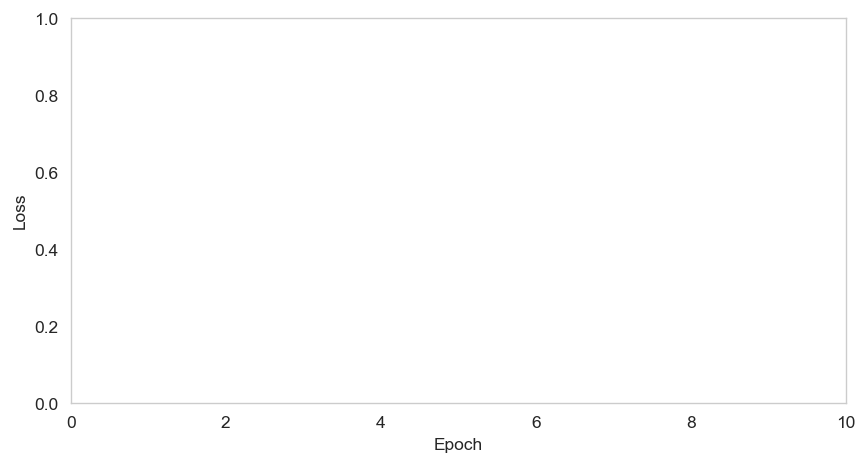

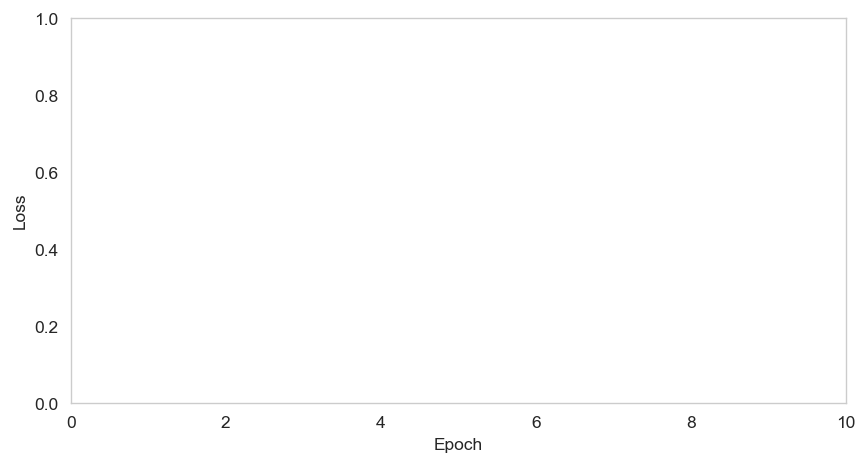

In [37]:
if not use_pretrained:
    [plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
    live_plot = init_live_plot()

    for era in range(N_era):
        for epoch in range(N_epoch):
            train_step(model, u1_action, KLdiv, optimizer, history)

            if epoch % print_freq == 0:
                #print_metrics(history, avg_last_N_epochs=print_freq)
                pass
                  
            if epoch % plot_freq == 0:
                update_plots(history, **live_plot)
                
            


else:
    print('Skipping training')

In [38]:
Y = history['loss']
print(Y)

[array(-264.24133328), array(-268.09951365), array(-269.13939665), array(-271.8094558), array(-273.94451339), array(-276.26897393), array(-275.48076081), array(-277.25610001), array(-276.99395934), array(-277.52339833)]


Text(0, 0.5, 'Loss')

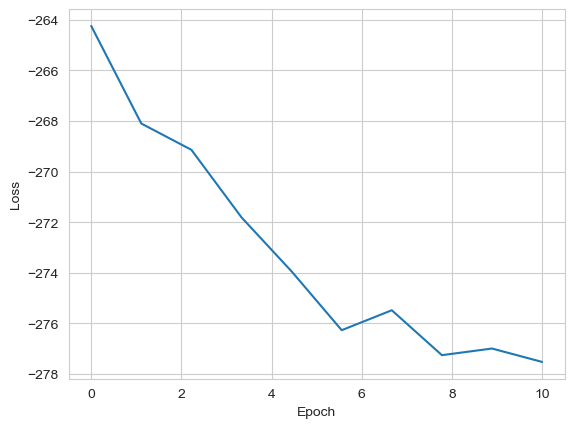

In [39]:
Y = history['loss']
X = np.linspace(0,N_epoch,N_epoch)
plt.plot(X,Y)
plt.grid('False')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
print('Model weights blob:\n===')
serialized_model = io.BytesIO()
torch.save(model['layers'].state_dict(), serialized_model)
print(base64.b64encode(serialized_model.getbuffer()).decode('utf-8'))
print('===')

In [ ]:
def serial_sample_generator(model, action, batch_size, N_samples):
    layers, prior = model['layers'], model['prior']
    layers.eval()
    x, logq, logp = None, None, None
    for i in range(N_samples):
        batch_i = i % batch_size
        if batch_i == 0:
            # we're out of samples to propose, generate a new batch
            x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
            logp = -action(x)
        yield x[batch_i], logq[batch_i], logp[batch_i]

In [ ]:
def make_mcmc_ensemble(model, action, batch_size, N_samples):
    history = {
        'x' : [],
        'logq' : [],
        'logp' : [],
        'accepted' : []
    }

    # build Markov chain
    sample_gen = serial_sample_generator(model, action, batch_size, N_samples)
    for new_x, new_logq, new_logp in sample_gen:
        if len(history['logp']) == 0:
            # always accept first proposal, Markov chain must start somewhere
            accepted = True
        else: 
            # Metropolis acceptance condition
            last_logp = history['logp'][-1]
            last_logq = history['logq'][-1]
            p_accept = torch.exp((new_logp - new_logq) - (last_logp - last_logq))
            p_accept = min(1, p_accept)
            draw = torch.rand(1) # ~ [0,1]
            if draw < p_accept:
                accepted = True
            else:
                accepted = False
                new_x = history['x'][-1]
                new_logp = last_logp
                new_logq = last_logq
        # Update Markov chain
        history['logp'].append(new_logp)
        history['logq'].append(new_logq)
        history['x'].append(new_x)
        history['accepted'].append(accepted)
    return history

In [ ]:
ensemble_size = 8192
u1_ens = make_mcmc_ensemble(model, u1_action, 64, ensemble_size)
print("Accept rate:", np.mean(u1_ens['accepted']))

In [ ]:
def bootstrap(x, *, Nboot, binsize):
    boots = []
    x = x.reshape(-1, binsize, *x.shape[1:])
    for i in range(Nboot):
        boots.append(np.mean(x[np.random.randint(len(x), size=len(x))], axis=(0,1)))
    return np.mean(boots), np.std(boots)

def topo_charge(x):
    P01 = torch_wrap(compute_u1_plaq(x, mu=0, nu=1))
    axes = tuple(range(1, len(P01.shape)))
    return torch.sum(P01, dim=axes) / (2*np.pi)

Q = grab(topo_charge(torch.stack(u1_ens['x'], axis=0)))

X_mean, X_err = bootstrap(Q**2, Nboot=100, binsize=16)
print(X_err)